In [1]:
import os
# import pandas as pd 
import polars as pl
import scanpy as sc
import numpy as np
import typing as tp
import re
from sklearn.decomposition import PCA
# from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import cross_validate, cross_val_score
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
%matplotlib inline
import os, shutil, glob
import seaborn as sns; sns.set_style("white")
import umap as umap

# import plotnine as gg
# from cytominer_eval import evaluate

os.getcwd()

/usr/local/lib/python3.8/dist-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.8/dist-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.8/dist-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argument 

'/scratch2-shared/david/colopaint3D/notebooks'

In [2]:
figformat = 'png'
dpi = 300
statarg = 'single'
OutputDir = f'./output/spher_colo52_v1/2_PCAUMAP'
if not os.path.exists(OutputDir): 
    os.makedirs(OutputDir)
FeatureDir = './output/spher_colo52_v1/1_FeaturesImages'


In [3]:
filenames = ['PB000137', 'PB000138', 'PB000139', 'PB000140', 'PB000141', 'PB000142']
statmets = ['SingleCell', 'MedianCell', 'MeanCell']

dropcols = ['Nuclei_Location_Center_X',
            'Nuclei_Location_Center_Y',
            'Location',
            'ImageNumber_',
            'Parent',
            'Children',
            '_ObjectNumber',
            '_Object_Number',
            '_Y',
            '_X' 
            ]


cons = ['pos_con', 'neg_con']
float_columns=[pl.col(pl.Float32),pl.col(pl.Float64)]

##### Correlation contains some kind of well information
# feature_groups = ['AreaShape'
#                   , 'Correlation'
#                   , 'Granularity'
#                   , 'Intensity'
#                   , 'Neighbors'
#                   , 'RadialDistribution'
#                   ]
# real_names = [x for x in training_data.columns if x.split('_')[0] in feature_groups]
# training_data = training_data[real_names]

In [4]:
def readData(filename, statmet='SingleCell'):
    df = pl.read_parquet(f'{FeatureDir}/{statmet}/{filename}.parquet')
    ##This here is important!!!!!!
    # df=df.select([c for c in df.columns if not is_meta_column(c)])
    # dataNpy = df.to_numpy(df.select(float_columns))
    ##
    onehot_list = df.select(['Metadata_cmpd_cmpdname'])['Metadata_cmpd_cmpdname'].unique().to_list()
    onehot_mapping = {name: i for i, name in enumerate(onehot_list)}
    df = df.with_columns(df['Metadata_cmpd_cmpdname'].map_elements(lambda name: oneHot(name, onehot_mapping)).alias('Metadata_cmpd_one_hot'))
    return df

# this is code from Dan
def is_meta_column(
    c:str,
    allowlist:tp.List[str]=["Metadata_Well","Metadata_Barcode","Metadata_AcqID","Metadata_Site"],
    denylist:tp.List[str]=[],
)->bool:
    """
        allowlist:
            the function will return False for these, no matter if they are metadata or not
        denylist:
            the function will return True for these, no matter if they are metadata or not
    """
    if c in allowlist:
        return False
    if c in denylist:
        return True
    for ex in '''
        Metadata
        ^Count
        ImageNumber
        Object
        Parent
        Children
        Plate
        Well
        Location
        _[XYZ]_
        _[XYZ]$
        BoundingBox
        Phase
        Orientation
        Angle
        Scale
        Scaling
        Width
        Height
        Group
        FileName
        PathName
        URL
        Execution
        ModuleError
        LargeBrightArtefact
        MD5Digest
        RadialDistribution_Frac
        Intensity_
    '''.split():
        if re.search(ex, c):
            return True
    return False


def oneHot(row, mapping):
    return mapping.get(row, -1)

def makePCA(df, name='', statmet='SingleCell' , n_components=2):
    dataN=df.select([c for c in df.columns if not is_meta_column(c)]).select(float_columns).to_numpy()
    pca_model = PCA(n_components=2)
    pca_model = pca_model.fit(dataN)
    pcaOut = pca_model.transform(dataN)
    df = df.with_columns([
    pl.Series('pc1', pcaOut[:, 0]),  
    pl.Series('pc2', pcaOut[:, 1])   
    ])

    hue = df['Metadata_cmpd_pathway'].to_list()
    cmap = sns.color_palette("husl", n_colors=len(df['Metadata_cmpd_pathway'].unique().to_list()))

    fig = plt.figure(
    # figsize=[14, 5]
    )
    ax = fig.add_subplot(111)
    ax.set_xlabel('PC 1', fontsize = 10)
    ax.set_ylabel('PC 2', fontsize = 10)
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    sns.scatterplot(x=df['pc1'].to_list(),
                    y=df['pc2'].to_list(),
                    palette=cmap, hue=hue,
                    marker='.',
                    ).set(title=f'PCA {name} All'
                )
    ax.set_facecolor('w')
    ax.get_legend().remove()
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()
    plt.close()
    return df

def makeUMAP(df, name='', statmet='SingleCell' , nn = 200, is_supervised=True, n_components=200, min_dist=0.2, spread= 5, n_epochs=None, metric='cosine', use_pca=True):
    dataN=df.select([c for c in df.columns if not is_meta_column(c)]).select(float_columns).to_numpy()
    umap_model = umap.UMAP(n_neighbors=nn
                        , min_dist=min_dist
                        , spread= spread
                        , n_epochs=n_epochs
                        , metric=metric
                        , n_jobs=-1
                        )
    if use_pca:
        pca_model = PCA(n_components=100)
        pca_model = pca_model.fit(dataN)
        dataN = pca_model.transform(dataN)
        
    if is_supervised:
        umapOut = umap_model.fit_transform(dataN, y=df['Metadata_cmpd_one_hot'].to_list())
        isSup = 'Supervised'
    else:
        umapOut = umap_model.fit_transform(dataN)
        isSup = 'Unsupervised'
    df = df.with_columns([
    pl.Series('umap1', umapOut[:, 0]),  
    pl.Series('umap2', umapOut[:, 1])   
    ])

    hue = df['Metadata_cmpd_pathway'].to_list()
    cmap = sns.color_palette("husl", n_colors=len(df['Metadata_cmpd_pathway'].unique().to_list()))

    fig = plt.figure(
    # figsize=[14, 5]
    )
    ax = fig.add_subplot(111)
    ax.set_xlabel('UMAP 1', fontsize = 10)
    ax.set_ylabel('UMAP 2', fontsize = 10)
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    sns.scatterplot(x=df['umap1'].to_list(),
                    y=df['umap2'].to_list(),
                    palette=cmap, hue=hue,
                    marker='.',
                    ).set(title=f'umap {name} All'
                )
    ax.set_facecolor('w')
    ax.get_legend().remove()
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # if not os.path.exists(f'{OutputDir}/{statmet}'):
    #     os.makedirs(f'{OutputDir}/{statmet}')
    # plt.savefig(f'{OutputDir}/{statmet}/{name}_umap{nn}nn_{isSup}.png')
    plt.show()
    plt.close()
    return df


In [5]:
filename = filenames[1]
# df = pl.read_parquet(f'{FeatureDir}/SingleCell/{filename}.parquet')
df = readData(filename, statmet='SingleCell')
# df['Metadata_cmpd_pathway'].unique().to_list()

In [6]:
# columns_containing_metadata = [col_name for col_name in df.columns if 'Metadata_' in col_name]
# columns_containing_metadata
# df2=df.select([c for c in df.columns if not is_meta_column(c)])
df_floats=df.select([c for c in df.columns if not is_meta_column(c)]).select(float_columns)

# for c in df.columns:
#     if is_meta_column(c):
#         print(c)


In [7]:
# df2 = df.filter(pl.col('Metadata_cmpd_pert_type').is_in(cons))
# cons = ['pos_con']
nodmso = ['pos_con']
wdmso = ['neg_con']
df2 = df.filter(pl.col('Metadata_cmpd_pert_type').is_in(cons))
df3 = df.filter(~pl.col('Metadata_cmpd_pert_type').is_in(nodmso))
df4 = df.filter(pl.col('Metadata_cmpd_pert_type').is_in(wdmso))

In [8]:
df2.shape[0]

39359

In [9]:
df3.shape[0]

369793

In [10]:
df4.shape[0]

33575

In [11]:
num_dmso = df2.filter(pl.col('Metadata_cmpd_pathway')== 'dmso').shape[0]
num_dmso = int(num_dmso*0.1)
print(num_dmso)
dmso_df = df2.filter(pl.col('Metadata_cmpd_pathway')=='dmso').sample(n=num_dmso, seed = 42)

df5 = df2.filter(~pl.col('Metadata_cmpd_pathway').is_in(['dmso']))

df5 = pl.concat([df5, dmso_df])
# df_with_id = df.with_column(pl.arange(0, df.height).alias('unique_id'))
# mask = pl.col('Metadata_cmpd_pathway').is_not('dmso') | df.join(dmso_rows, on=list(df.columns), how='inner').with_column(pl.lit(True).alias('keep'))

# print(df5.shape)
cols = df5['Metadata_cmpd_pathway'].unique().to_list()
for column in cols:
    # print(column)
    print(f"{column}:   {df5.filter(pl.col('Metadata_cmpd_pathway')==column).shape[0]}")

3357
etop:   1252
dmso:   3357
stau:   1629
fenb:   1526
sorb:   1377


In [12]:
cols = df3['Metadata_cmpd_pathway'].unique().to_list()
for column in cols:
    # print(column)
    print(f"{column}:   {df3.filter(pl.col('Metadata_cmpd_pathway')==column).shape[0]}")

Apoptosis:   23583
PI3K/Akt/mTOR:   66255
TGF-beta/Smad:   12853
dmso:   33575
DNA Damage:   59221
Cytoskeletal Signaling:   11672
Protein Tyrosine Kinase:   68105
Epigenetics:   7752
Proteases:   2496
Others:   10342
Cell Cycle:   24013
MAPK:   35904
JAK/STAT:   14022


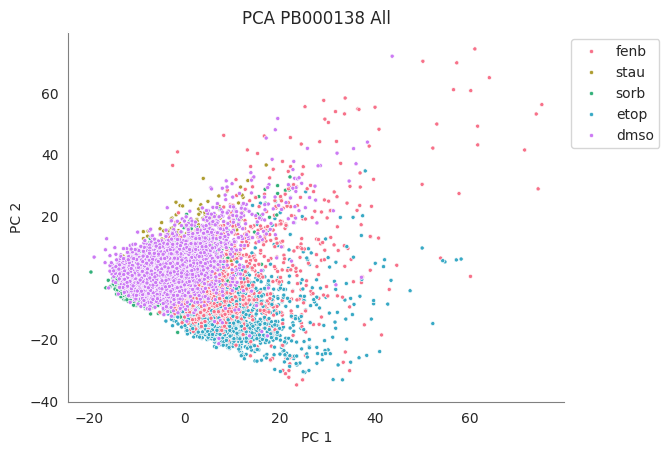

In [13]:
_ = makePCA(df5, name=filename)
# df2 = makeUMAP(df2, name=filename, is_supervised=False, use_pca=False)


/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


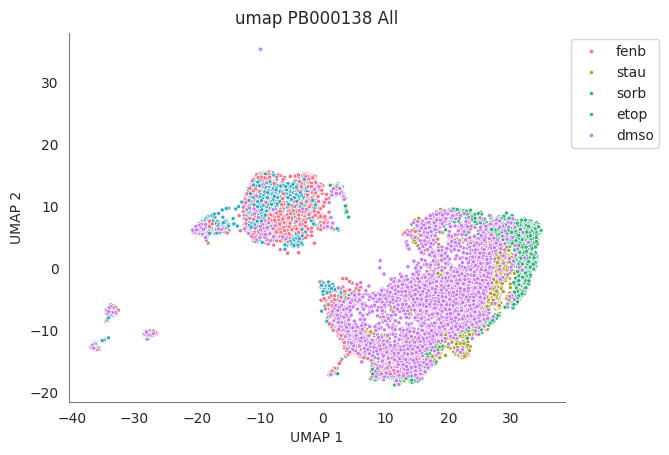

In [14]:
_ = makeUMAP(df5, name=filename, is_supervised=False, use_pca=True)

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


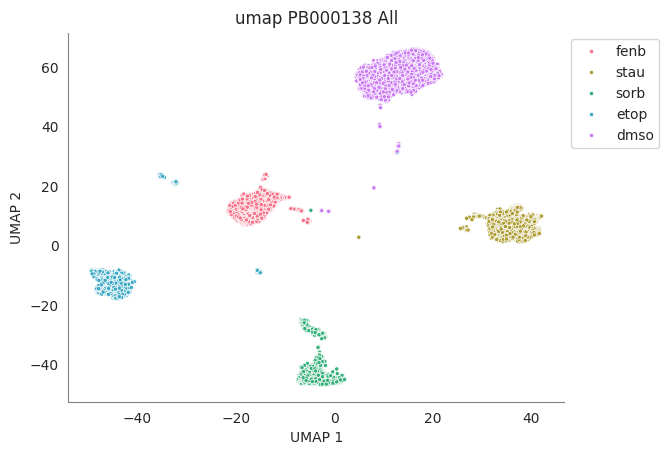

In [15]:
_ = makeUMAP(df5, name=filename, is_supervised=True, use_pca=True)

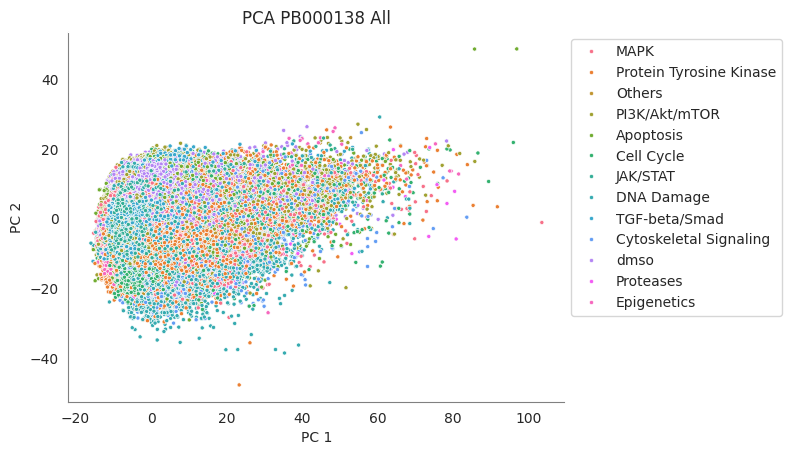

In [16]:
_ = makePCA(df3, name=filename)

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


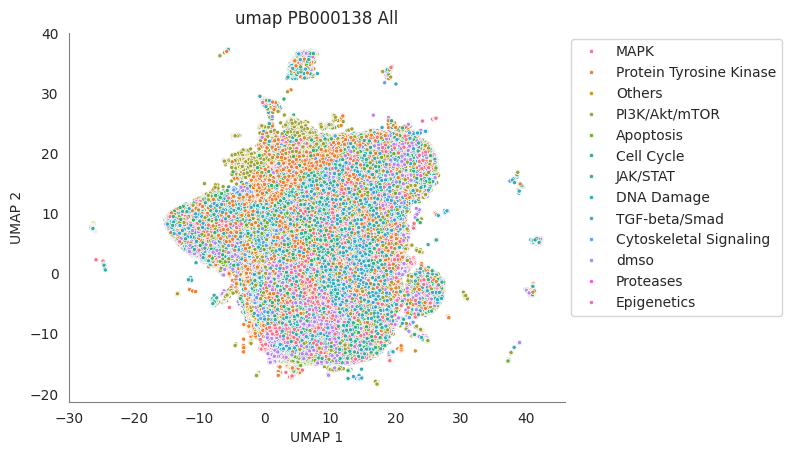

In [17]:
_ = makeUMAP(df3, name=filename, is_supervised=False, use_pca=True)

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


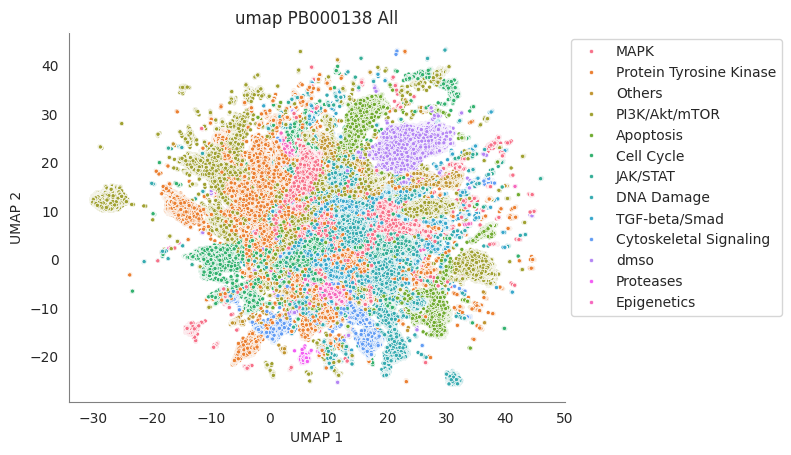

In [18]:
_ = makeUMAP(df3, name=filename, is_supervised=True, use_pca=True)

In [19]:
# dataN=df.select([c for c in df.columns if not is_meta_column(c)]).select(float_columns).to_numpy()

In [20]:
# df['pc1'].max()

In [21]:
# min_dist=0.2
# spread= 5
# n_epochs=None
# metric='cosine'
# for filename in filenames:
#     df = readData(filename)
#     _ = makePCA(df, name=filename)
#     # _ = makeUMAP(dataNpy, dataL, name=filename)
#     _ = makeUMAP(df, name=filename, nn=250)
#     _ = makeUMAP(df, name=filename, nn=300, is_supervised=False)


In [22]:


# for statmet in statmets:
#     for filename in filenames:
#         dataNpy, dataL = readData(filename, statmet=statmet)
#         _ = makePCA(dataNpy, dataL, name=filename, statmet=statmet)
#         # _ = makeUMAP(dataNpy, dataL, name=filename, statmet=statmet)
#         _ = makeUMAP(dataNpy, dataL, name=filename, statmet=statmet, nn=150)
#         # _ = makeUMAP(dataNpy, dataL, name=filename, statmet=statmet, is_supervised=False)
#         _ = makeUMAP(dataNpy, dataL, name=filename, statmet=statmet, nn=150, is_supervised=False)

In [23]:
# for filename in filenames:
#     dataNpy, dataL = readData(filename)
#     _ = makeMultiPlot(dataNpy, dataL, model_type='PCA', n_components=5)
#     _ = makeMultiPlot(dataNpy, dataL, model_type='UMAP', n_components=5)
#     _ = makeMultiPlot(dataNpy, dataL, model_type='UMAP', is_supervised=False, n_components=5)

In [24]:

# for filename in filenames:
#     dataNpy, dataL = readData(filename, statmet='Mean')
#     _ = makeMultiPlot(dataNpy, dataL, model_type='PCA', statmet='Mean', n_components=5, nn=100)
#     _ = makeMultiPlot(dataNpy, dataL, model_type='UMAP', statmet='Mean', n_components=5, nn=100)
#     _ = makeMultiPlot(dataNpy, dataL, model_type='UMAP', statmet='Mean', is_supervised=False, n_components=5, nn=100)

In [25]:
# for filename in filenames:
#     dataNpy, dataL = readData(filename, statmet='Median')
#     _ = makeMultiPlot(dataNpy, dataL, model_type='PCA', statmet='Median', n_components=5, nn=100)
#     _ = makeMultiPlot(dataNpy, dataL, model_type='UMAP', statmet='Median', n_components=5, nn=100)
#     _ = makeMultiPlot(dataNpy, dataL, model_type='UMAP', statmet='Median', is_supervised=False, n_components=5, nn=100)